In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from time import sleep
import socket,time,requests
from bs4 import BeautifulSoup
import tkinter as tk

import yfinance as yf
import datetime




In [38]:
ticker='AKSEN.IS'
start="2022-06-01"
end=str(datetime.date.today() +datetime.timedelta(days=1))
aksen=yf.download(ticker,start,end)


[*********************100%***********************]  1 of 1 completed


In [39]:
aksen.index=pd.to_datetime(aksen.index)
aksen

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-06-01,21.240000,23.219999,21.240000,23.219999,22.097910,19980095
2022-06-02,23.500000,24.320000,23.120001,23.700001,22.554716,19128761
2022-06-03,23.900000,25.120001,23.480000,24.900000,23.696724,15260434
2022-06-06,25.000000,25.440001,24.440001,24.660000,23.468323,10872762
2022-06-07,24.660000,25.219999,24.420000,24.680000,23.487356,8632857
...,...,...,...,...,...,...
2023-06-15,32.700001,33.200001,32.360001,32.639999,32.639999,7716708
2023-06-16,33.000000,33.340000,31.780001,31.780001,31.780001,12332566
2023-06-19,31.200001,31.260000,29.580000,29.580000,29.580000,13952905


In [97]:
close=pd.DataFrame(aksen["Close"])

close


,Close
Date,
2022-06-01,23.219999
2022-06-02,23.700001
2022-06-03,24.900000
2022-06-06,24.660000
2022-06-07,24.680000
...,...
2023-06-15,32.639999
2023-06-16,31.780001
2023-06-19,29.580000


In [98]:
rolling_app5=close.rolling(window=5).mean()
rolling_app14=close.rolling(window=14).mean()
rolling_app21=close.rolling(window=21).mean()



In [99]:
MAs=pd.concat([close,rolling_app5,rolling_app14,rolling_app21],axis=1)
MAs.columns=["Close","short","mid","long"]


In [100]:
MAs.dropna(axis=0,inplace=True)
MAs

,Close,short,mid,long
Date,,,,
2022-06-29,24.340000,25.480000,24.935714,24.677143
2022-06-30,24.080000,25.076000,24.945714,24.718095
2022-07-01,25.200001,24.944000,25.104286,24.789524
2022-07-04,24.900000,24.840000,25.178571,24.789524
2022-07-05,25.000000,24.704000,25.228571,24.805714
...,...,...,...,...
2023-06-15,32.639999,34.007999,33.441428,31.818095
2023-06-16,31.780001,33.368000,33.645714,31.983809
2023-06-19,29.580000,32.356000,33.527143,31.998095


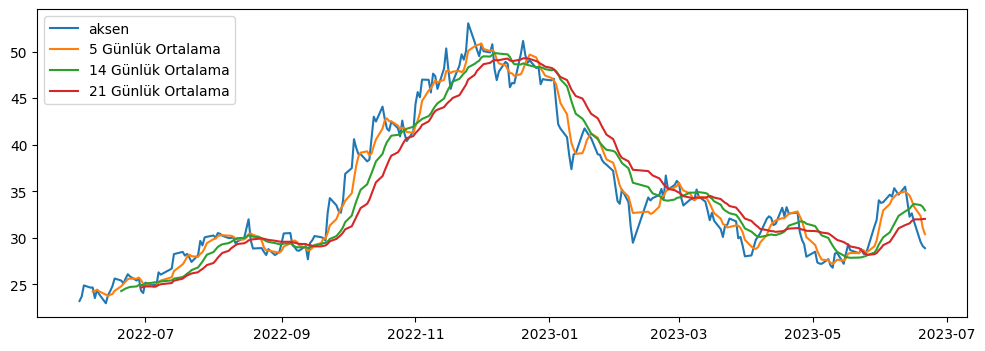

In [103]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(close.index,close,label='aksen')
ax.plot(rolling_app5.index,rolling_app5,label='5 Günlük Ortalama')
ax.plot(rolling_app14.index,rolling_app14,label='14 Günlük Ortalama')
ax.plot(rolling_app21.index,rolling_app21,label='21 Günlük Ortalama')
ax.legend(loc='upper left')


In [104]:
def buy_sell_MA(data,opt=50):
    buy_sell=[]
    buy_signal=[]
    sell_signal=[]
    flag=42

    up=data[(np.array(data["short"]-data["mid"])>0) & (np.array(data["short"]-data["long"])>0)]
    down=data[(np.array(data["short"]-data["mid"])<0) & (np.array(data["short"]-data["long"])<0)]
    ups=np.percentile(np.array(up["short"]-up["mid"]),opt)
    downs=np.percentile(np.array(down["short"]-down["long"]),opt)


    for i in range(0,len(data)):
       if (data["short"][i]>data["mid"][i]+ups) & (data["short"][i]>data["long"][i]+ups):
            buy_signal.append(np.nan)
            if flag !=1:
                sell_signal.append(data["Close"][i])
                buy_sell.append(data["Close"][i])
                flag=1
            else:
                sell_signal.append(np.nan)
       elif(data["short"][i]<data["mid"][i]+downs)&(data["short"][i]<data["long"][i]+downs):
            sell_signal.append(np.nan)
            if flag!=0:
                buy_signal.append(data["Close"][i])
                buy_sell.append(-data["Close"][i])
                flag=0
            else:
                buy_signal.append(np.nan)
       else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)

    operations=np.array(buy_sell)
    operations=operations[~np.isnan(operations)]

    neg=0
    pos=0

    for i in range(len(operations)):
        if operations[i]<0:
            neg=i
            break
    for i in range(1,len(operations)):
        if operations[-i]>0:
            pos=i-1
            break
    
    PL=np.sum(operations)
    

    
    
    return (buy_signal,sell_signal,PL)





In [105]:
MAs["Buy"]=buy_sell_MA(MAs)[0]
MAs["Sell"]=buy_sell_MA(MAs)[1]

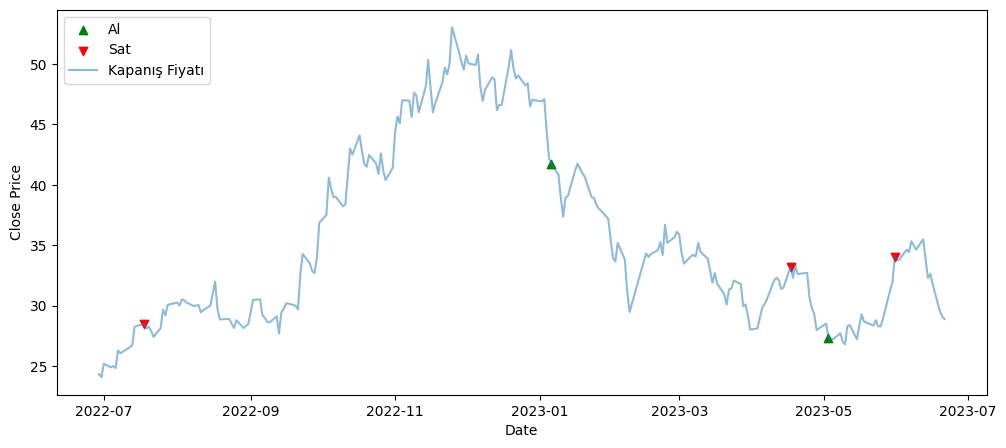

In [106]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Buy"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sell"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

## Optimizing percentile variable to find best performance

In [107]:
def kar(percentile):
    MAs["Buy"]=buy_sell_MA(MAs,percentile)[0]
    MAs["Sell"]=buy_sell_MA(MAs,percentile)[1]
    al=MAs["Buy"]
    al=al.dropna(axis=0)
    sat=MAs["Sell"]
    sat=sat.dropna(axis=0)
    sat_val=sat.values
    al_val=al.values
    res=[]
    if len(al_val)==len(sat_val):
        for i in range(len(al_val)):
           res.append(sat_val[i]/al_val[i])
    elif len(al_val)>len(sat_val):
        al_val=np.delete(al_val,-1)
        for j in range(len(sat_val)):
           res.append(sat_val[j]/al_val[j])
    elif (len(sat_val)>len(al_val)):
        sat_val=np.delete(sat_val,0)
        for k in range(len(al_val)):
            res.append(sat_val[k]/al_val[k])
    
        

    
       

    

    df=pd.DataFrame()
    df["Kar"]=res

    return np.prod(df["Kar"])

In [108]:
MAs["Buy"]=buy_sell_MA(MAs,50)[0]
MAs["Sell"]=buy_sell_MA(MAs,50)[1]
al=MAs["Buy"]
al=al.dropna(axis=0)
sat=MAs["Sell"]
sat=sat.dropna(axis=0)
sat_val=sat.values
al_val=al.values

In [109]:
percentile=range(1,100)



In [110]:
kardf=pd.DataFrame()
kardf["Percentile"]=percentile

In [111]:

for i in range(len(percentile)):
  kardf.loc[i,1]=kar(percentile[i])

In [112]:
kardf.columns=["Percentile","Performance"]
kardf=kardf.sort_values(by="Performance",ascending=False)
kardf

,Percentile,Performance
98,99,1.560000
95,96,1.404844
97,98,1.373010
96,97,1.373010
36,37,1.074383
...,...,...
67,68,0.715369
66,67,0.715369
65,66,0.715369
69,70,0.705756


In [113]:
MAs["Buy"]=buy_sell_MA(MAs,kardf["Percentile"].values[0])[0]
MAs["Sell"]=buy_sell_MA(MAs,kardf["Percentile"].values[0])[1]

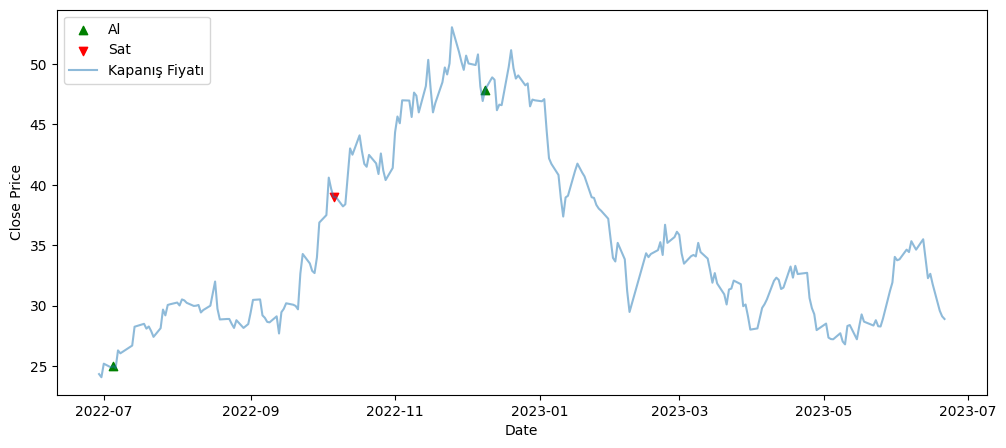

In [114]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Buy"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sell"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

In [115]:
al=MAs["Buy"]
al=al.dropna(axis=0)
al

Date
2022-07-05    25.000000
2022-12-09    47.880001
Name: Buy, dtype: float64

In [116]:
sat=MAs["Sell"]
sat=sat.dropna(axis=0)
sat


Date
2022-10-06    39.0
Name: Sell, dtype: float64

In [117]:
del al["2022-12-09"]

In [118]:
sat_val=sat.values
al_val=al.values


In [119]:
res=[]

for i in range(len(al_val)):
    res.append((sat_val[i]/al_val[i]))

In [120]:
df=pd.DataFrame()
df["Kar"]=res
df

,Kar
0,1.56


In [121]:
res0=[100]
for i in range(len(df.index)):
    res0.append(res0[i]*df["Kar"].loc[i])

df["Eldeki Para"]=res0[1:]
df


,Kar,Eldeki Para
0,1.56,156.0


In [122]:
karlilik=df["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 56.00000000000001
